Loaded 108077 entries from C:\Users\PC\Desktop\grat\question_answers.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\relationships.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\objects.json
Processed 5000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 10000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 15000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 20000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 25000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Final Training set size: 20000
Final Validation set size: 5000
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1558s 2s/step - accuracy: 0.0085 - loss: 7.9717 - val_accuracy: 0.0086 - val_loss: 7.7009
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1524s 2s/step -

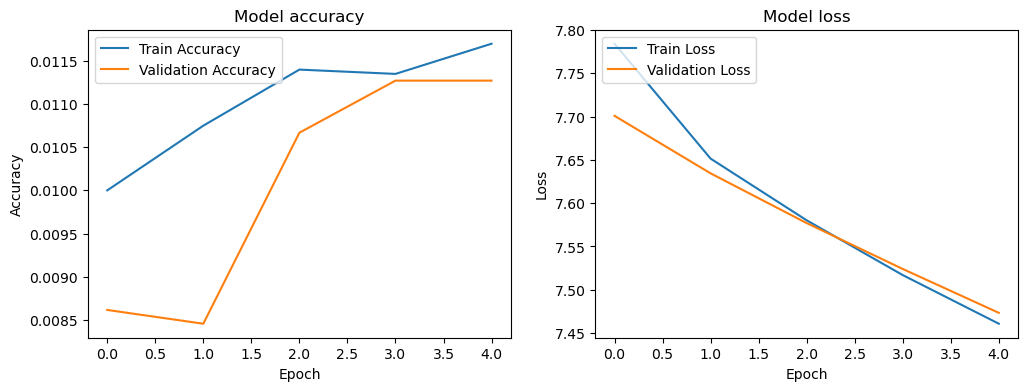

In [1]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 32
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 25000
chunk_size = 5000  # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model

# Function to create question model
def create_question_model(vocab_size, max_length, embedding_dim):
    question_input = Input(shape=(max_length,), name='question_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(question_input)
    x = Bidirectional(LSTM(512))(x)
    question_model = Model(inputs=question_input, outputs=x)
    return question_model

# Function to create additional context model (relations or objects)
def create_context_model(vocab_size, max_length, embedding_dim, context_name):
    context_input = Input(shape=(max_length,), name=f'{context_name}_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(context_input)
    //transformers
    //x = Bidirectional(LSTM(512))(x)
    context_model = Model(inputs=context_input, outputs=x)
    return context_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_question_model(vocab_size, max_question_length, embedding_dim)
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_context_model(vocab_size, max_relation_length, embedding_dim, 'relation')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_context_model(vocab_size, max_object_length, embedding_dim, 'object')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])

    # Remove attention mechanism as it might be incorrectly configured
    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    x = Dense(num_answers, activation='softmax')(x)

    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = r'C:\Users\PC\Desktop\grat\VG_100K'
questions_file = r'C:\Users\PC\Desktop\grat\question_answers.json'
relations_file = r'C:\Users\PC\Desktop\grat\relationships.json'
objects_file = r'C:\Users\PC\Desktop\grat\objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = []
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=5,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch)

vqa_model.save('vqa_model_advanced.h5')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)


Loaded 108077 entries from C:\Users\PC\Desktop\grat\question_answers.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\relationships.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\objects.json
Processed 5000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 10000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 15000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 20000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 25000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Final Training set size: 20000
Final Validation set size: 5000
Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1576s 2s/step - accuracy: 0.0087 - loss: 7.9491 - val_accuracy: 0.0086 - val_loss: 7.7012
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1529s 2s/step

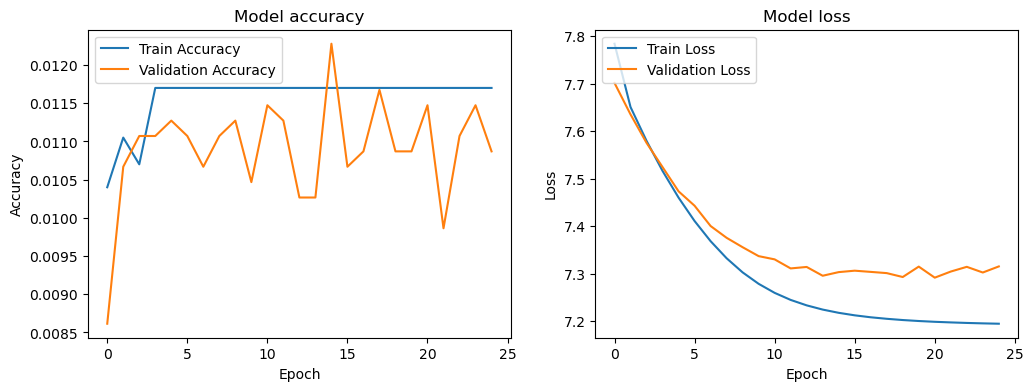

In [3]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 32
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 25000
chunk_size = 5000  # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model

# Function to create question model
def create_question_model(vocab_size, max_length, embedding_dim):
    question_input = Input(shape=(max_length,), name='question_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(question_input)
    x = Bidirectional(LSTM(512))(x)
    question_model = Model(inputs=question_input, outputs=x)
    return question_model

# Function to create additional context model (relations or objects)
def create_context_model(vocab_size, max_length, embedding_dim, context_name):
    context_input = Input(shape=(max_length,), name=f'{context_name}_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(context_input)
    x = Bidirectional(LSTM(512))(x)
    context_model = Model(inputs=context_input, outputs=x)
    return context_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_question_model(vocab_size, max_question_length, embedding_dim)
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_context_model(vocab_size, max_relation_length, embedding_dim, 'relation')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_context_model(vocab_size, max_object_length, embedding_dim, 'object')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])

    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    x = Dense(num_answers, activation='softmax')(x)

    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = r'C:\Users\PC\Desktop\grat\VG_100K'
questions_file = r'C:\Users\PC\Desktop\grat\question_answers.json'
relations_file = r'C:\Users\PC\Desktop\grat\relationships.json'
objects_file = r'C:\Users\PC\Desktop\grat\objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = [] 
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=25,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch)

vqa_model.save('vqa_model_advanced.keras')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)


Loaded 108077 entries from C:\Users\PC\Desktop\grat\question_answers.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\relationships.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\objects.json
Processed 5000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 10000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 15000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 20000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 25000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Final Training set size: 20000
Final Validation set size: 5000
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1871s 3s/step - accuracy: 0.0191 - loss: 7.7195 - val_accuracy: 0.0266 - val_loss: 7.4159
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1788s 3s/st

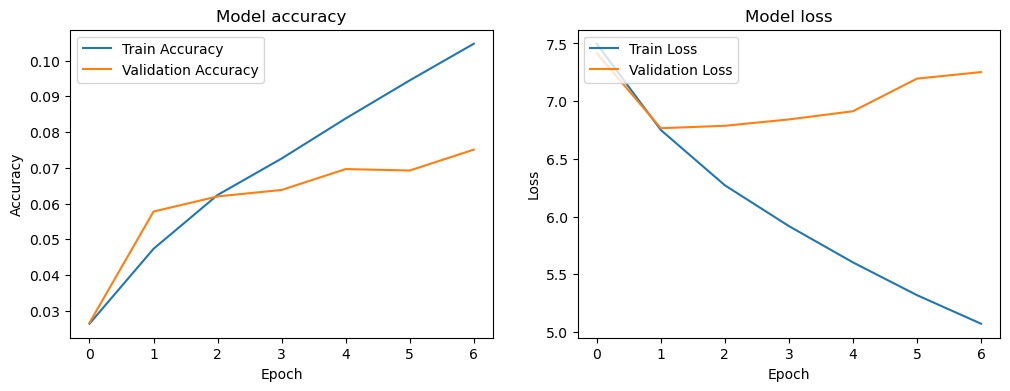

In [2]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 32
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 25000
chunk_size = 5000  # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image

# Enhanced Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model

# Function to create question model
def create_question_model(vocab_size, max_length, embedding_dim):
    question_input = Input(shape=(max_length,), name='question_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(question_input)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)  # Reduced LSTM units
    x = Bidirectional(LSTM(256))(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    question_model = Model(inputs=question_input, outputs=x)
    return question_model

# Function to create additional context model (relations or objects)
def create_context_model(vocab_size, max_length, embedding_dim, context_name):
    context_input = Input(shape=(max_length,), name=f'{context_name}_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(context_input)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)  # Reduced LSTM units
    x = Bidirectional(LSTM(256))(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    context_model = Model(inputs=context_input, outputs=x)
    return context_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_question_model(vocab_size, max_question_length, embedding_dim)
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_context_model(vocab_size, max_relation_length, embedding_dim, 'relation')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_context_model(vocab_size, max_object_length, embedding_dim, 'object')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])

    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = Dense(num_answers, activation='softmax')(x)

    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Reduced learning rate
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = r'C:\Users\PC\Desktop\grat\VG_100K'
questions_file = r'C:\Users\PC\Desktop\grat\question_answers.json'
relations_file = r'C:\Users\PC\Desktop\grat\relationships.json'
objects_file = r'C:\Users\PC\Desktop\grat\objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = [] 
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=700,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping])

vqa_model.save('vqa_model_optimized.keras')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)


Loaded 108077 entries from C:\Users\PC\Desktop\grat\question_answers.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\relationships.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\objects.json
Processed 5000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 10000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 15000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 20000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 25000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Final Training set size: 20000
Final Validation set size: 5000
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1693s 3s/step - accuracy: 0.0094 - loss: 7.8242 - val_accuracy: 0.0166 - val_loss: 7.7105 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━

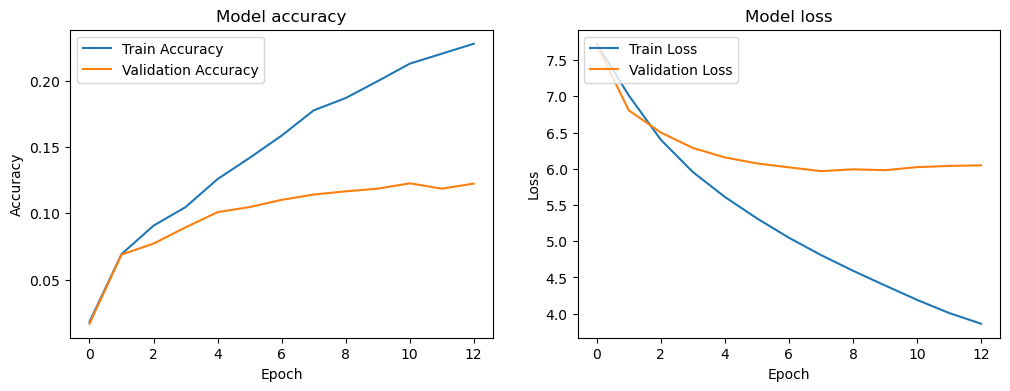

In [3]:
#code 7
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Bidirectional, LSTM, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 32
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 25000
chunk_size = 5000  # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image
//remove
# Enhanced Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
//dropout 0.25 
# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model
//remove lstm and  put transform 
# Function to create question model
def create_question_model(vocab_size, max_length, embedding_dim):
    question_input = Input(shape=(max_length,), name='question_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(question_input)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)  # Reduced LSTM units
    x = Bidirectional(LSTM(256))(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    question_model = Model(inputs=question_input, outputs=x)
    return question_model

# Function to create additional context model (relations or objects)
def create_context_model(vocab_size, max_length, embedding_dim, context_name):
    context_input = Input(shape=(max_length,), name=f'{context_name}_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(context_input)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)  # Reduced LSTM units
    x = Bidirectional(LSTM(256))(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    context_model = Model(inputs=context_input, outputs=x)
    return context_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_question_model(vocab_size, max_question_length, embedding_dim)
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_context_model(vocab_size, max_relation_length, embedding_dim, 'relation')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_context_model(vocab_size, max_object_length, embedding_dim, 'object')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])
// attention or transformer incoder  
// remove maybe    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
// decoder ..
    x = Dense(num_answers, activation='softmax')(x)


    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Reduced learning rate
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = r'C:\Users\PC\Desktop\grat\VG_100K'
questions_file = r'C:\Users\PC\Desktop\grat\question_answers.json'
relations_file = r'C:\Users\PC\Desktop\grat\relationships.json'
objects_file = r'C:\Users\PC\Desktop\grat\objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = [] 
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=50,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping, lr_scheduler])

vqa_model.save('vqa_model_optimized.keras')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)


Loaded 108077 entries from C:\Users\PC\Desktop\grat\question_answers.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\relationships.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\objects.json
Processed 5000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 10000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 15000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 20000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Processed 25000 entries.
Chunk processed with 5000 images.
Training set size: 4000
Validation set size: 1000
Final Training set size: 20000
Final Validation set size: 5000


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_input (InputLayer)   │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relation_input (InputLayer)   │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ object_input (InputLayer)     │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 30, 300)           │       3,000,000 │ question_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 30, 300)           │       3,000,000 │ relation_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 30, 300)           │       3,000,000 │ object_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 26, 128)           │         192,128 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 26, 128)           │         192,128 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 26, 128)           │         192,128 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 13, 128)           │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 13, 128)           │               0 │ conv1d_2[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 13, 128)           │               0 │ conv1d_4[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 9, 128)            │          82,048 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 9, 128)            │          82,048 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 9, 128)            │          82,048 │ max_pooling1d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ conv1d_1[0][0]             │
│ (GlobalMaxPooling1D)          │                           │               

 Total params: 80,274,280 (306.22 MB)

 Trainable params: 80,228,417 (306.05 MB)

 Non-trainable params: 45,863 (179.16 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1511s 1s/step - accuracy: 9.7847e-04 - loss: 7.9066 - val_accuracy: 0.0242 - val_loss: 7.6444 - learning_rate: 1.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1481s 1s/step - accuracy: 0.0149 - loss: 7.6515 - val_accuracy: 0.0415 - val_loss: 7.4127 - learning_rate: 1.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1483s 1s/step - accuracy: 0.0342 - loss: 7.3710 - val_accuracy: 0.0524 - val_loss: 7.1795 - learning_rate: 1.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1481s 1s/step - accuracy: 0.0479 - loss: 7.0317 - val_accuracy: 0.0590 - val_loss: 6.9773 - learning_rate: 1.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1482s 1s/step - accuracy: 0.0562 - loss: 6.7311 - val_accuracy: 0.0608 - val_loss: 6.8166 - learning_rate: 1.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1480s 1s/step - accuracy: 0.0580 - loss: 6.5582 - val_accuracy: 0.0652 - val_loss: 6.6887 - learning_rate: 1.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━

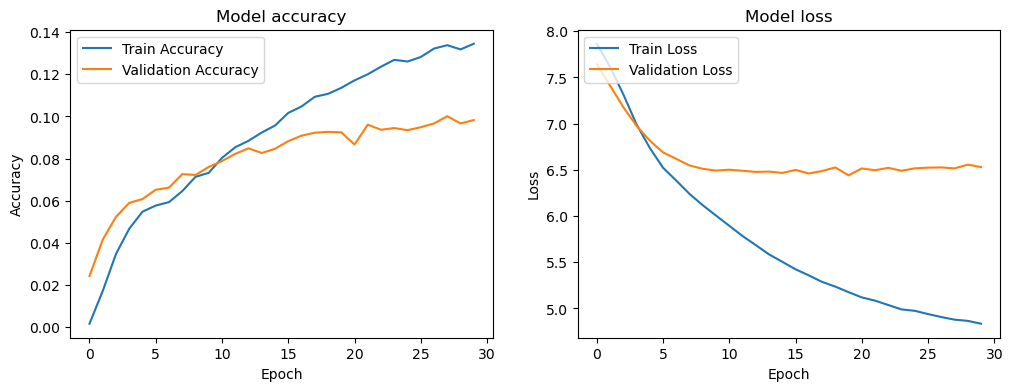

In [1]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 16  # Reduced batch size
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 25000
chunk_size = 5000  # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image

# Enhanced Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model

# Function to create text CNN model
def create_text_cnn_model(vocab_size, max_length, embedding_dim, input_name):
    text_input = Input(shape=(max_length,), name=input_name)
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
    x = Conv1D(128, 5, activation='relu')(x)  # Reduced Conv1D units
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 5, activation='relu')(x)  # Reduced Conv1D units
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    text_model = Model(inputs=text_input, outputs=x)
    return text_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_text_cnn_model(vocab_size, max_question_length, embedding_dim, 'question_input')
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_text_cnn_model(vocab_size, max_relation_length, embedding_dim, 'relation_input')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_text_cnn_model(vocab_size, max_object_length, embedding_dim, 'object_input')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])

    x = Dense(1024, activation='relu')(combined_features)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    x = Dense(num_answers, activation='softmax')(x)

    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Reduced learning rate
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = r'C:\Users\PC\Desktop\grat\VG_100K'
questions_file = r'C:\Users\PC\Desktop\grat\question_answers.json'
relations_file = r'C:\Users\PC\Desktop\grat\relationships.json'
objects_file = r'C:\Users\PC\Desktop\grat\objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = [] 
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

# Print the model summary
vqa_model.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=50,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping, lr_scheduler])

vqa_model.save('vqa_model_optimized.keras')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)


In [ ]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 16  # Reduced batch size
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 10
chunk_size = 2 # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image

# Enhanced Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model

# Function to create text CNN model
def create_text_cnn_model(vocab_size, max_length, embedding_dim, input_name):
    text_input = Input(shape=(max_length,), name=input_name)
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
    x = Conv1D(128, 5, activation='relu')(x)  # Reduced Conv1D units
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, 5, activation='relu')(x)  # Reduced Conv1D units
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    text_model = Model(inputs=text_input, outputs=x)
    return text_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_text_cnn_model(vocab_size, max_question_length, embedding_dim, 'question_input')
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_text_cnn_model(vocab_size, max_relation_length, embedding_dim, 'relation_input')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_text_cnn_model(vocab_size, max_object_length, embedding_dim, 'object_input')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])

    x = Dense(1024, activation='relu')(combined_features)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Added dropout for regularization
    x = BatchNormalization()(x)  # Added batch normalization
    x = Dense(num_answers, activation='softmax')(x)

    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Reduced learning rate
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = r'C:\Users\PC\Desktop\grat\VG_100K'
questions_file = r'C:\Users\PC\Desktop\grat\question_answers.json'
relations_file = r'C:\Users\PC\Desktop\grat\relationships.json'
objects_file = r'C:\Users\PC\Desktop\grat\objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = [] 
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

# Print the model summary
vqa_model.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=50,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping, lr_scheduler])

vqa_model.save('vqa_model_optimized.keras')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)


Loaded 108077 entries from C:\Users\PC\Desktop\grat\question_answers.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\relationships.json
Loaded 108077 entries from C:\Users\PC\Desktop\grat\objects.json
Processed 2 entries.
Chunk processed with 2 images.
Training set size: 1
Validation set size: 1
Processed 4 entries.
Chunk processed with 2 images.
Training set size: 1
Validation set size: 1
Processed 6 entries.
Chunk processed with 2 images.
Training set size: 1
Validation set size: 1
Processed 8 entries.
Chunk processed with 2 images.
Training set size: 1
Validation set size: 1
Processed 10 entries.
Chunk processed with 2 images.
Training set size: 1
Validation set size: 1
Final Training set size: 5
Final Validation set size: 5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ question_input (InputLayer)   │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relation_input (InputLayer)   │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ object_input (InputLayer)     │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 30, 300)           │       3,000,000 │ question_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 30, 300)           │       3,000,000 │ relation_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 30, 300)           │       3,000,000 │ object_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 26, 128)           │         192,128 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 26, 128)           │         192,128 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 26, 128)           │         192,128 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 13, 128)           │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 13, 128)           │               0 │ conv1d_2[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 13, 128)           │               0 │ conv1d_4[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 9, 128)            │          82,048 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 9, 128)            │          82,048 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 9, 128)            │          82,048 │ max_pooling1d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ conv1d_1[0][0]             │
│ (GlobalMaxPooling1D)          │                           │               

 Total params: 79,025,125 (301.46 MB)

 Trainable params: 78,979,262 (301.28 MB)

 Non-trainable params: 45,863 (179.16 KB)

Epoch 1/50
   3475/Unknown 1968s 556ms/step - accuracy: 0.6782 - loss: 0.7036

In [ ]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Embedding, Bidirectional, LSTM, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = (224, 224)
batch_size = 32
max_question_length = 30
max_relation_length = 30
max_object_length = 30
vocab_size = 10000
embedding_dim = 300
num_images_to_use = 25000
chunk_size = 5000  # Process data in chunks

# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image = np.array(image) / 255.0
    return image

# Function to create image feature extractor model
def create_image_model(input_shape):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    image_model = Model(inputs=base_model.input, outputs=x)
    return image_model

# Function to create question model
def create_question_model(vocab_size, max_length, embedding_dim):
    question_input = Input(shape=(max_length,), name='question_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(question_input)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    question_model = Model(inputs=question_input, outputs=x)
    return question_model

# Function to create additional context model (relations or objects)
def create_context_model(vocab_size, max_length, embedding_dim, context_name):
    context_input = Input(shape=(max_length,), name=f'{context_name}_input')
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(context_input)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    context_model = Model(inputs=context_input, outputs=x)
    return context_model

# Function to create VQA model
def create_vqa_model(image_shape, vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers):
    image_input = Input(shape=image_shape, name='image_input')
    image_model = create_image_model(image_shape)
    image_features = image_model(image_input)

    question_model = create_question_model(vocab_size, max_question_length, embedding_dim)
    question_input = question_model.input
    question_features = question_model.output

    relation_model = create_context_model(vocab_size, max_relation_length, embedding_dim, 'relation')
    relation_input = relation_model.input
    relation_features = relation_model.output

    object_model = create_context_model(vocab_size, max_object_length, embedding_dim, 'object')
    object_input = object_model.input
    object_features = object_model.output

    combined_features = Concatenate()([image_features, question_features, relation_features, object_features])
    x = Dense(512, activation='relu')(combined_features)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Dense(num_answers, activation='softmax')(x)

    vqa_model = Model(inputs=[image_input, question_input, relation_input, object_input], outputs=x)
    vqa_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return vqa_model

# Load and verify JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} entries from {file_path}")
    return data

# Extract and process data in chunks
def process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    image_paths = []
    questions = []
    answers = []
    relations = []
    objects = []
    relation_data_map = {entry['image_id']: entry['relationships'] for entry in relations_data if 'relationships' in entry}
    object_data_map = {entry['image_id']: entry['objects'] for entry in objects_data}
    count = 0

    for entry in qa_data:
        if count >= num_images_to_use:
            break
        try:
            image_id = entry['id']
            image_path = os.path.join(image_folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                for qa in entry['qas']:
                    image_paths.append(image_path)
                    questions.append(qa['question'])
                    answers.append(qa['answer'])
                    relation_str = ' '.join([rel['predicate'] for rel in relation_data_map.get(image_id, [])])
                    relations.append(relation_str)
                    object_str = ' '.join([obj['names'][0] for obj in object_data_map.get(image_id, [])])
                    objects.append(object_str)
                    count += 1
                    if count % chunk_size == 0:
                        print(f"Processed {count} entries.")
                        yield image_paths, questions, answers, relations, objects
                        image_paths, questions, answers, relations, objects = [], [], [], [], []
                    if count >= num_images_to_use:
                        break
        except KeyError as e:
            print(f"Missing key in entry: {e}, entry: {entry}")
    
    if image_paths:
        yield image_paths, questions, answers, relations, objects

# Example usage
image_folder = 'path/to/your/image_folder'
questions_file = 'path/to/your/questions.json'
relations_file = 'path/to/your/relations.json'
objects_file = 'path/to/your/objects.json'

qa_data = load_json(questions_file)
relations_data = load_json(relations_file)
objects_data = load_json(objects_file)

# Initialize lists to store final processed data
final_train_image_paths = []
final_val_image_paths = []
final_train_questions = []
final_val_questions = [] 
final_train_answers = []
final_val_answers = []
final_train_relations = []
final_val_relations = []
final_train_objects = []
final_val_objects = []

# Process data in chunks
for image_paths, questions, answers, relations, objects in process_data_in_chunks(qa_data, relations_data, objects_data, image_folder, chunk_size, num_images_to_use):
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(questions + relations + objects)
    question_sequences = tokenizer.texts_to_sequences(questions)
    relation_sequences = tokenizer.texts_to_sequences(relations)
    object_sequences = tokenizer.texts_to_sequences(objects)

    padded_questions = pad_sequences(question_sequences, maxlen=max_question_length, padding='post')
    padded_relations = pad_sequences(relation_sequences, maxlen=max_relation_length, padding='post')
    padded_objects = pad_sequences(object_sequences, maxlen=max_object_length, padding='post')

    unique_answers = list(set(answers))
    num_answers = len(unique_answers)  # Update num_answers
    answer_to_index = {answer: idx for idx, answer in enumerate(unique_answers)}
    indexed_answers = np.array([answer_to_index[ans] for ans in answers])

    (train_image_paths, val_image_paths, train_questions, val_questions, train_answers, val_answers,
     train_relations, val_relations, train_objects, val_objects) = train_test_split(
        image_paths, padded_questions, indexed_answers, padded_relations, padded_objects, test_size=0.2, random_state=42)

    final_train_image_paths.extend(train_image_paths)
    final_val_image_paths.extend(val_image_paths)
    final_train_questions.extend(train_questions)
    final_val_questions.extend(val_questions)
    final_train_answers.extend(train_answers)
    final_val_answers.extend(val_answers)
    final_train_relations.extend(train_relations)
    final_val_relations.extend(val_relations)
    final_train_objects.extend(train_objects)
    final_val_objects.extend(val_objects)

    # Debugging output to file
    with open("debug_output.txt", "a") as f:
        f.write(f"Chunk processed with {len(image_paths)} images.\n")
        f.write(f"Total questions: {len(questions)}\n")
        f.write(f"Total answers: {len(answers)}\n")
        f.write(f"Total relations: {len(relations)}\n")
        f.write(f"Total objects: {len(objects)}\n")

    print(f"Chunk processed with {len(image_paths)} images.")
    print(f"Training set size: {len(train_image_paths)}")
    print(f"Validation set size: {len(val_image_paths)}")

# Final train and validation sets
train_image_paths = final_train_image_paths
val_image_paths = final_val_image_paths
train_questions = final_train_questions
val_questions = final_val_questions
train_answers = final_train_answers
val_answers = final_val_answers
train_relations = final_train_relations
val_relations = final_val_relations
train_objects = final_train_objects
val_objects = final_val_objects

print(f"Final Training set size: {len(train_image_paths)}")
print(f"Final Validation set size: {len(val_image_paths)}")

# Function to create data generator
def data_generator(image_paths, questions, answers, relations, objects, batch_size, image_shape, max_question_length, max_relation_length, max_object_length):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            
            batch_images = []
            batch_questions = []
            batch_answers = []
            batch_relations = []
            batch_objects = []
            
            for idx in batch_indices:
                image = tf.image.decode_image(tf.io.read_file(image_paths[idx]), channels=3)
                image = tf.image.resize(image, image_shape)
                image = tf.cast(image, tf.float32) / 255.0
                
                question = questions[idx]
                answer = answers[idx]
                relation = relations[idx]
                object_ = objects[idx]
                
                question = list(map(int, question))
                relation = list(map(int, relation))
                object_ = list(map(int, object_))
                
                question = question[:max_question_length]
                question += [0] * (max_question_length - len(question))
                
                relation = relation[:max_relation_length]
                relation += [0] * (max_relation_length - len(relation))
                
                object_ = object_[:max_object_length]
                object_ += [0] * (max_object_length - len(object_))
                
                batch_images.append(image)
                batch_questions.append(question)
                batch_answers.append(answer)
                batch_relations.append(relation)
                batch_objects.append(object_)
                
            batch_images = np.array(batch_images)
            batch_questions = np.array(batch_questions)
            batch_answers = np.array(batch_answers)
            batch_relations = np.array(batch_relations)
            batch_objects = np.array(batch_objects)
            
            yield ({'image_input': tf.convert_to_tensor(batch_images), 
                    'question_input': tf.convert_to_tensor(batch_questions, dtype=tf.int32),
                    'relation_input': tf.convert_to_tensor(batch_relations, dtype=tf.int32),
                    'object_input': tf.convert_to_tensor(batch_objects, dtype=tf.int32)}, 
                   tf.convert_to_tensor(batch_answers, dtype=tf.int32))

train_data_gen = data_generator(train_image_paths, train_questions, train_answers, train_relations, train_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)
val_data_gen = data_generator(val_image_paths, val_questions, val_answers, val_relations, val_objects, batch_size, (224, 224), max_question_length, max_relation_length, max_object_length)

train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

vqa_model = create_vqa_model((224, 224, 3), vocab_size, max_question_length, max_relation_length, max_object_length, embedding_dim, num_answers)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vqa_model.fit(train_data_gen,
                        steps_per_epoch=train_steps_per_epoch,
                        epochs=50,
                        validation_data=val_data_gen,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping, lr_scheduler])

vqa_model.save('vqa_model_optimized.keras')

def plot_metrics(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

plot_metrics(history)
